In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
#Import Libraries
import csv
import random
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
import wordcloud
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

# Machine Learning
from sklearn.preprocessing import normalize
import scipy.cluster.hierarchy as sch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics
from sklearn.decomposition import PCA

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **1. Data Cleaning**
The dataset with selected columns of title, abstract, publish time and authors is imported. 

**The cleaning steps follow:**
1. Drop duplicates in the abstract column 
2. Drop rows containing null values 
3. Convert title and abstract to lowercase 
4. Remove stopwords in abstract

The result dataset contains 321,013 rows. Due to the long process time, the cleaned dataset is saved and used for the following tasks.


In [ ]:
# Import dataset
df = pd.read_csv("/content/drive/My Drive/metadata.csv", usecols=['title','abstract','publish_time','authors'])

In [ ]:
# Drop duplicates and NA
df = df.drop_duplicates(subset='abstract', keep="first")
df=df.dropna()

In [ ]:
# Print dataframe shape 
print('The number of rows:', df.shape[0])
print('The number of columns:', df.shape[1])

The number of rows: 321013
The number of columns: 4


In [ ]:
# Convert characters to lowercase 
df.title = df.title.str.lower()
df.abstract= df.abstract.str.lower()

In [ ]:
# Remove stop words 
def remove_stopwords(text): 
    text_tokens = word_tokenize(text)
    result = [word for word in text_tokens if word not in stopwords.words('english')]
    return ' '.join(result)

In [ ]:
df['cleaned_abstract'] = df.abstract.apply(lambda x: remove_stopwords(x))

In [ ]:
# df.to_csv('/content/drive/My Drive/cleaned_abstract.csv', index=False)

In [3]:
# Import dataset
# df = pd.read_csv("/content/drive/My Drive/cleaned_abstract.csv", usecols=['title','cleaned_abstract','publish_time','authors'])

In [4]:
# Convert to string
df.title = df.title.astype(str)
df.cleaned_abstract = df.cleaned_abstract.astype(str)

# Convert to datetime
df.publish_time = pd.to_datetime((df['publish_time']))

## **2. Data Visualization and Exploratory Data Analysis**

### **2.1 Visualization on Keywords in Abstract**
As the underlying purpose is to find insights of COVID-19. The wordcloud analysis is based on paper abstract published after 2020. Therefore, it helps to investigate the major research direction specifically related to COVID-19 virus. 

**Observations**: 
- Keywords such as "covid", "gedv", "patient" and "incubation period" are found most frequent in the abstract. 
- The word "gedv" is acronym of global end-diastolic volume, which meansures the combined volume of all the four cardiac chambers. And dexmedetomidine is a kind of pain medication. It seems that majority research papers are focused on patient treatment and cure. 
- There are few papers discuss the transmission methods of COVID-19. The only keyword related to transmission is "contact". 

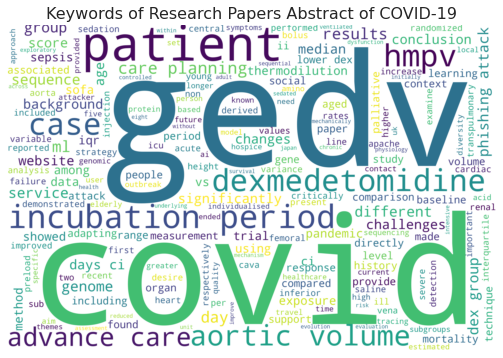

In [5]:
# Wordcloud on Abstract
text = df[df['publish_time'].dt.year >= 2020]['cleaned_abstract'].values
abstract_wordcloud = WordCloud(width = 3000, height = 2000, background_color="#FFFFFF").generate(str(text))

plt.figure(figsize=(12,6))
plt.imshow(abstract_wordcloud, interpolation='bilinear')
plt.title('Keywords of Research Papers Abstract of COVID-19', fontsize=16)
plt.axis("off")
plt.show()

### **2.2 Visualization on the transmission modes of Coronavirus** 

The transmission of COVID-19 can occur through direct, indirect, or close contact with infected people. The modes of transmission are categoried as: 
1. **Contact and droplet transmission** <br>
Transmission is throgh infected secretions such as saliva or respiratory droplets, which are expelled when infected people cough, sneeze, talk or sing. 
2. **Airborne transmission** <br>
It is defined as the spread of infectious agent caused by the dissemination of droplet nuclei (aerosols) that remain infectious when suspended in air over long distances and time. 
3. **Fomite transmission** <br>
Respiratory secretions or droplets expelled by infected people can contaminate surfaces and objects, creating fomites (contaminated surfaces). 
4. **Other modes of transmission** <br> 
COVID-19 can be detected in other biological samples, including the urine and feces of some patients. <br> Some studies show that COVID-19 might transmit through bloodborne transmission and intrauterine transmission. 

In the following precedures, keywords search helps filter out paper discussed about the above transmission modes. The figure shows the number of paper of each transmission modes. There are above 10,000 paper about contact and droplet transmission, which proves that that direct contact is the major transmission of COVID-19. However, to date there was no sufficient evidence to prove that other modes are valid. And it is definitely worth more research. 

Link: https://www.who.int/news-room/commentaries/detail/transmission-of-sars-cov-2-implications-for-infection-prevention-precautions

In [6]:
# Keywords related to contact and droplet transmission 
keywords_cd = 'droplet|cough|sneeze&trasmission'

# Keywords realted to airborne transmission 
keywords_air = 'airborne|aerosol&trasmission'

# Keywords related to fomite transmission 
keywords_femite = 'contaminate|fomite&trasmission'

# Keywords related other transmission
keywords_other = 'urine|feces|bloodborne|intrauterine&trasmission'

# Add all keywords in a list
keywords = [keywords_cd, keywords_air, keywords_femite, keywords_other]

# All all modes
modes = ['Contact&Droplet', 'Airborne', 'Fomite', 'Other']

# Create a temp dataframe 
temp1 = df.copy()

# Check for abstract containing keywords related to transmission 
for mode, keyword in zip(modes, keywords):
  temp1[mode] = temp1['cleaned_abstract'].str.contains(keyword)

In [7]:
print('Number of papers about Contact and Droplet transmission:', temp1['Contact&Droplet'].sum())
print('Number of papers about Airborne transmission:', temp1['Airborne'].sum())
print('Number of papers about Fomite transmission:', temp1['Fomite'].sum())
print('Number of papers about Other transmission:', temp1['Other'].sum())

Number of papers about Contact and Droplet transmission: 10122
Number of papers about Airborne transmission: 1862
Number of papers about Fomite transmission: 1789
Number of papers about Other transmission: 4319


In [8]:
count = [temp1['Contact&Droplet'].sum(), temp1['Airborne'].sum(), temp1['Fomite'].sum(), temp1['Other'].sum()]

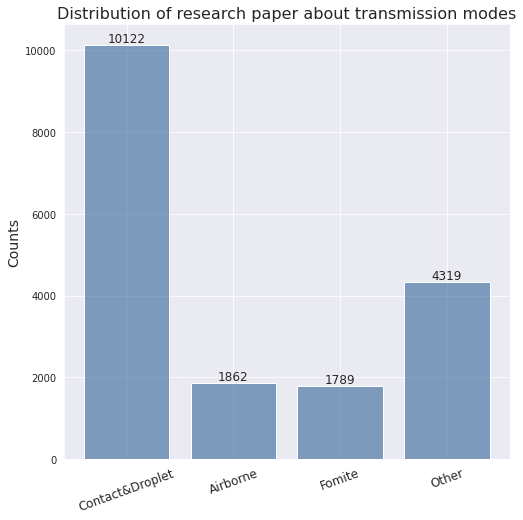

In [9]:
fig = plt.figure(figsize=(8,8))
plt.bar(range(4), count, color=(0.2, 0.4, 0.6, 0.6))
plt.xticks(np.arange(4),('Contact&Droplet','Airborne','Fomite', 'Other'),fontsize=12,rotation=20)
plt.ylabel('Counts', fontsize=14)
plt.title('Distribution of research paper about transmission modes',fontsize=16)
for a,b in zip([i for i in range(4)], count):  
    plt.text(a,b,'%d'%b,ha='center',va='bottom',fontsize=12)
plt.show()

### **2.3 Visualization on papers about long term effect of COVID-19**

The common symptoms of COVID-19 are well-known. However, COVID-19 could result in long-term symptoms even after recovery. Although COVID-19 seems a disease that primarily affects the lungs, it can damage many other organs as well. The organ damage may increase the risk of long-term health problems. Organs affected by COVID-19 include: 
- **Heart** <br> 
The future risk of heart failure or other heart complications may be increased.
- **Lungs** <br> 
COVID-19 can cause long-standing damage to the tiny air sacs in the lungs. The resulting scar can lead to long-term breathing problems. 
- **Brain** <br> 
COVID-19 can cause strokes, seizures and Guillain-Barre syndrome. It may also increase the risk of developing Parkinson's disease and Alzheimer's disease. 
- **Blood clots and vessel** 
COVID-19 can make blood cells more likely to clump up and form clots. It may also weaken blood vessels and cause them to leak, which contributes to potentially long-lasting problems with the liver and kidneys.
 
Other long-term effects include: 
- **Mood and fatigue** 
People who are recovered from COVID-19 might be more likely to later develop post-tranumatic stress syndrome, depression and axiety. 

The steps below aims to find papers talk about the long-term effects. And the count is plotted. 

Link: https://www.mayoclinic.org/diseases-conditions/coronavirus/in-depth/coronavirus-long-term-effects/art-20490351


In [10]:
# Keywords of heart disease
keywords_heart = 'heart failure|heart complication'

# Keywords of lungs disease
keywords_lungs = 'lungs|breathing'

# Keywords of brain damage
keywords_brain = 'brain|strokes|seizures|guillan-barre|parkinson|alzheimer'

# Keywords of blood issues
keywords_blood = 'blood cell clump|blood clot|vessel leak'

# Keywords of mood and fatigue
keywords_mood = 'post-tranumatic stress|depression|anxiety'

keywords_effect = [keywords_heart, keywords_lungs, keywords_brain, keywords_blood, keywords_mood]

diseases = ['Heart_Disease', 'Lungs_Disease', 'Brain_Damage', 'Blood_Issues', 'Mood&Fatigue']

# Create a temp dataframe 
temp2 = df.copy()

# Check for abstract containing keywords related to transmission 
for disease, keyword in zip(diseases, keywords_effect):
  temp2[disease] = temp2['cleaned_abstract'].str.contains(keyword)

In [11]:
print('Number of papers about heart disease:', temp2['Heart_Disease'].sum())
print('Number of papers about lung disease:', temp2['Lungs_Disease'].sum())
print('Number of papers about brain damage:', temp2['Brain_Damage'].sum())
print('Number of papers about blood issues:', temp2['Blood_Issues'].sum())
print('Number of papers about mood and fatigue:', temp2['Mood&Fatigue'].sum())

Number of papers about heart disease: 2016
Number of papers about lung disease: 5878
Number of papers about brain damage: 7892
Number of papers about blood issues: 139
Number of papers about mood and fatigue: 10425


In [12]:
count_disease = [temp2['Heart_Disease'].sum(), temp2['Lungs_Disease'].sum(), temp2['Brain_Damage'].sum(), temp2['Blood_Issues'].sum(), temp2['Mood&Fatigue'].sum()]

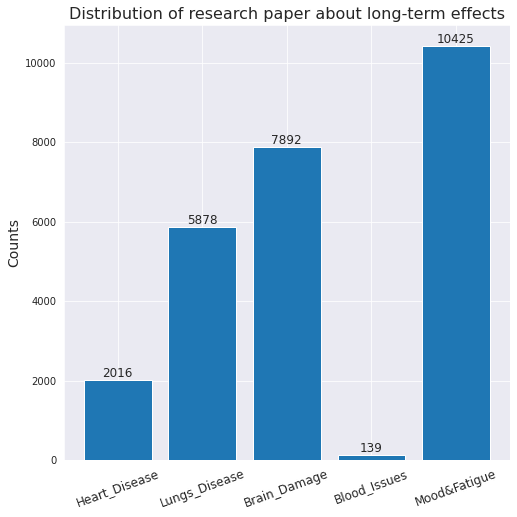

In [13]:
fig = plt.figure(figsize=(8,8))
plt.bar(range(5), count_disease)
plt.xticks(np.arange(5),('Heart_Disease','Lungs_Disease','Brain_Damage', 'Blood_Issues', 'Mood&Fatigue'),fontsize=12,rotation=20)
plt.ylabel('Counts', fontsize=14)
plt.title('Distribution of research paper about long-term effects',fontsize=16)
for a,b in zip([i for i in range(5)], count_disease):  
    plt.text(a,b,'%d'%b,ha='center',va='bottom',fontsize=12)
plt.show()

## **3. Model Selection and Fitting to Data**

In part 2, temporatory dataframes are created to store transmission related and long-term symptoms related papers. In this part, clustering algorithm is used to categories these sorted articles. From the clusters, we hope to gain more insights of transmission and symptoms of COVID-19. <br>

1. **Encoding Method** <br>
TF-IDF was used to encode words based on frequency. 

2. **Model Selection Justification** <br>
Kmeans is the most well-known and computationally fast algorithm. With the increasing size of the dataset, the computation time of Kmeans will increase as the need of store the whole dataset in memory. Mini batch kmeans uses small random batches of data, thus, less requirement for memory. At each iteration, a new random sample is obtained and used to update the clusters. The iteration is repeated until convergence. As the number of iteration increases, the effect of unseen data is reduced, so convergence can be detected when no changes in the cluster. Mini batch kmeans can significantly save computation time while not lose much of the cluster quality. <br>

3. **Determine optimal number of clusters and implementation** <br>
A disvantage of kmeans is the number of groups/classes must be defined. The most common approach to solve this question is called elbow method. It involves the running the algorithm multiple times over a loop, with an increasing number of clusters and then plotting the sum of squared distances. The optimal cluster number is at the bend of an elbow. Then, the optimal number of cluster is fitted on the abstract to form clusters. 

4. **Top words search in clusters** <br>
In each cluster, top 12 words are found for the guess of main direction of each cluster. 

5. **PCA Analysis** <br>
PCA is applied to visualize how clusters are grouped. 

### **3.1 Model on transmission related articles** 
The kmeans on the transmission related articles help to sort into groups.  

In [14]:
# Filter out transmission related articles 
transmission_df = temp1[temp1.iloc[:,4:].sum(axis=1) > 0]

In [15]:
# Print dataframe shape 
print('The number of rows:', transmission_df.shape[0])
print('The number of columns:', transmission_df.shape[1])

The number of rows: 16718
The number of columns: 8


In [16]:
# Apply TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_tran = tfidf.fit_transform(transmission_df.cleaned_abstract)

In [17]:
# kmeans iteratively to determine k 
inertia = []
K = range(1,50)
for k in K:
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=0, batch_size=2500)
    model = kmeans.fit(X_tran)
    inertia.append(kmeans.inertia_)

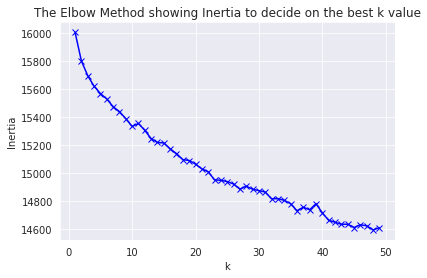

In [18]:
# Plot the elbow method 
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing Inertia to decide on the best k value')
plt.show()

The optimal number of clusters is 10. 

In [19]:
Best_kmeanModel = MiniBatchKMeans(n_clusters=10,  random_state=0, batch_size=3000).fit(X_tran)
labels_Best_kmeanModel = Best_kmeanModel.labels_

In [20]:
print('Silhouette coefficient =', metrics.silhouette_score(X_tran, labels_Best_kmeanModel, metric = 'euclidean'))
print('CV score =', metrics.calinski_harabasz_score(X_tran.todense(), labels_Best_kmeanModel))

Silhouette coefficient = 0.005557244352503182
CV score = 77.07662423167879


In [21]:
# Find important words in each cluster 
def cluster_keywords(X, labels, words, n_keywords): 
  temp = pd.DataFrame(X.todense()).groupby(labels).mean()

  for i in range(pd.DataFrame(labels).nunique()[0]): 
    print('Cluster ', (i+1))
    print(', '.join(words[j] for j in np.argsort(-temp.iloc[i,:])[:n_keywords]))

In [22]:
cluster_keywords(X_tran, labels_Best_kmeanModel, tfidf.get_feature_names(), 12)

Cluster  1
patients, urine, group, treatment, samples, study, clinical, calves, blood, patient, feces, results
Cluster  2
cov, sars, samples, rna, viral, pcr, surfaces, wastewater, detection, rt, virus, positive
Cluster  3
cov, sars, covid, 19, respiratory, coronavirus, disease, syndrome, severe, acute, infection, transmission
Cluster  4
patients, 19, covid, ct, cases, clinical, chest, pneumonia, symptoms, severe, disease, fever
Cluster  5
children, ci, 95, 19, covid, symptoms, patients, clinical, fever, cough, studies, cases
Cluster  6
covid, 19, virus, influenza, health, de, viruses, transmission, respiratory, disease, infection, pandemic
Cluster  7
air, masks, airborne, transmission, aerosol, droplets, mask, droplet, particles, risk, covid, 19
Cluster  8
cells, mice, mhv, murine, cell, virus, protein, expression, viral, infection, mouse, replication
Cluster  9
dental, procedures, covid, 19, dentists, transmission, aerosol, aerosols, dentistry, infection, practice, risk
Cluster  10
c

**Results Interpretion** <br> 
Based on the top words, we can make an assumption about the research direction of each cluster. 

- **Cluster 1**: The topic may be related to sample study of patients' secretion and blood. 
- **Cluster 2**: It discussed multiple kinds of coronavirus, and are detected on contaminated surfaces, wastewater. 
- **Cluster 3**: It mainly talks about disease resulted from respiratory transmission. 
- **Cluster 4**: The cluster involves clinical cases of patients. 
- **Cluster 5**: This cluster is more about children clinical cases. 
- **Cluster 6** This cluster is similar to cluster 3, and contains some french words. 
- **Cluster 7**: It talks about the airborne transmission, and the preventative solution is to wear facial masks. 
- **Cluster 8**: This cluster contains articles that research for virus on mice. 
- **Cluster 9**: This clusters talks about risk and practices of aerosol transmission from dentists. 
- **Cluster 10**: It includes clinical cases having the symptoms of fever and cough. 

In [23]:
# Apply PCA to visualiza and understand the clusters 
centroids_best_kmeanModel = pd.DataFrame(data=Best_kmeanModel.cluster_centers_, columns=tfidf.get_feature_names())

# Instantiate
pca = PCA(n_components=2)
pca.fit(centroids_best_kmeanModel)

# Transform the data using the PCA fit
PC_scores = pca.transform(centroids_best_kmeanModel)
data_scores = pca.transform(X_tran.todense())

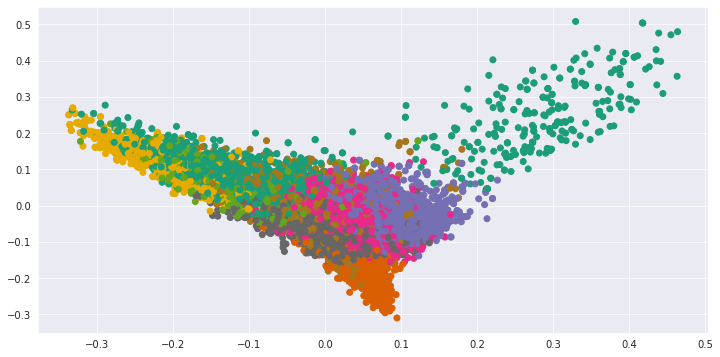

In [24]:
clusters = pd.DataFrame({'Cluster': Best_kmeanModel.labels_})
clusters['Index'] = clusters.index

fig = plt.figure(figsize=(12,6))
plt.scatter(data_scores[:,0], data_scores[:,1], c=clusters['Cluster'], cmap="Dark2_r")
plt.show()

### **3.2 Model on symptoms related articles** 

In [25]:
symptom_df = temp2[temp2.iloc[:,4:].sum(axis=1) > 0]

In [26]:
# Print dataframe shape 
print('The number of rows:', symptom_df.shape[0])
print('The number of columns:', symptom_df.shape[1])

The number of rows: 25303
The number of columns: 9


In [27]:
# Apply TF-IDF
X_sym = tfidf.fit_transform(symptom_df.cleaned_abstract)

In [28]:
# kmeans iteratively to determine k 
inertia = []
K = range(1,50)
for k in K:
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=0, batch_size=2500)
    model = kmeans.fit(X_sym)
    inertia.append(kmeans.inertia_)

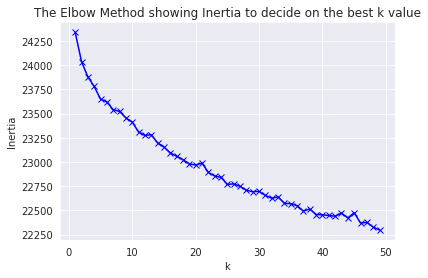

In [29]:
# Plot the elbow method 
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing Inertia to decide on the best k value')
plt.show()

Take 12 as the optimal number of cluster. 

In [30]:
Best_kmeanModel = MiniBatchKMeans(n_clusters=12,  random_state=0, batch_size=3000).fit(X_sym)
labels_Best_kmeanModel = Best_kmeanModel.labels_

In [31]:
print('Silhouette coefficient =', metrics.silhouette_score(X_sym, labels_Best_kmeanModel, metric = 'euclidean'))
print('CV score =', metrics.calinski_harabasz_score(X_sym.todense(), labels_Best_kmeanModel))

Silhouette coefficient = 0.006291764348913808
CV score = 97.78858266827461


In [32]:
cluster_keywords(X_sym, labels_Best_kmeanModel, tfidf.get_feature_names(), 12)

Cluster  1
de, la, depression, en, anxiety, el, depressive, patients, suicide, symptoms, et, les
Cluster  2
covid, 19, patients, disease, respiratory, coronavirus, acute, sars, severe, neurological, cov, infection
Cluster  3
patients, 19, covid, stroke, 95, ci, ct, hospital, mortality, vs, clinical, group
Cluster  4
ad, pd, cognitive, dementia, studies, patients, alzheimer, disease, review, quality, trials, systematic
Cluster  5
anxiety, covid, 19, depression, psychological, stress, health, symptoms, pandemic, mental, students, study
Cluster  6
brain, patients, treatment, cerebral, blood, clinical, disease, heart, using, may, system, effects
Cluster  7
health, mental, covid, 19, pandemic, anxiety, care, depression, social, stress, psychological, people
Cluster  8
lung, respiratory, breathing, ventilation, lungs, virus, pressure, air, ventilator, pulmonary, infection, influenza
Cluster  9
cov, sars, ace2, infection, covid, respiratory, 19, coronavirus, severe, virus, cells, syndrome
Clu

**Results Interpretion** <br> 
Based on the top words, we can guess the main idea of each cluster. 
- **Cluster 1**: The topic may be related to mental health issues of patients and possible suicide behaviour. 
- **Cluster 2**: It discussed about respiratory and neurological disease of COVID-19. 
- **Cluster 3**: It mainly talks about the patients mortality. 
- **Cluster 4**: The cluster involves study to dementia and alzheimer disease. 
- **Cluster 5**: This cluster is about students suffered from psychological stress. 
- **Cluster 6** This cluster is about patients may have brain and heart disease. 
- **Cluster 7**: It is similar to cluster 5, but all people suffered from anxiety and depression during the pandemic. 
- **Cluster 8**: This cluster contains breathing and lung disease, and proper treatment. 
- **Cluster 9**: This clusters talks about general coronavirus syndrome. 
- **Cluster 10**: It talks about students during the lockdown may feel depressed and anxious.
- **Cluster 11**: This cluster contains articles that tested on mice to investigate symptoms. 
- **Cluster 12**: It talks about pregnant women during the lockdown may feel depressed and anxious. 


In [33]:
# Apply PCA to visualiza and understand the clusters 
centroids_best_kmeanModel = pd.DataFrame(data=Best_kmeanModel.cluster_centers_, columns=tfidf.get_feature_names())

# Instantiate
pca = PCA(n_components=2)
pca.fit(centroids_best_kmeanModel)

# Transform the data using the PCA fit
PC_scores = pca.transform(centroids_best_kmeanModel)
data_scores = pca.transform(X_sym.todense())

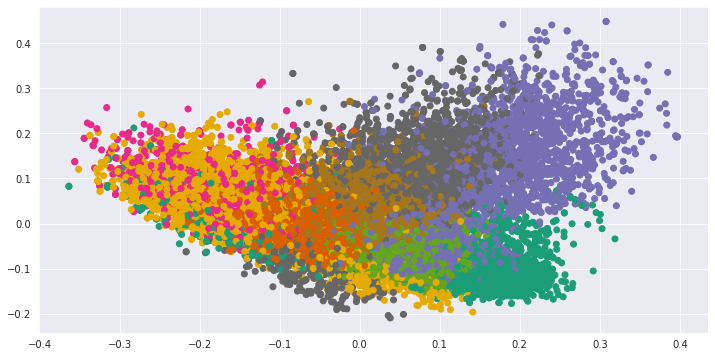

In [34]:
clusters = pd.DataFrame({'Cluster': Best_kmeanModel.labels_})
clusters['Index'] = clusters.index

fig = plt.figure(figsize=(12,6))
plt.scatter(data_scores[:,0], data_scores[:,1], c=clusters['Cluster'], cmap="Dark2_r")
plt.show()

## **4. Deriving insights about policy and guidance to tackle the outbreak based on model findings** 

Based on the above findings of transmission and symptoms, I would like to suggest some actions for scientists, health professionals and government respectively to tackle the outbreak. 

**For scientists:**
1. Investigate other transmission modes <br>
The recent studies have proven that transmission of COVID-19 is through contact, droplets, aerosols and containminated surfaces. However, there was no formal research about whether COVID-19 would transmit through patients' secretion or blood. It is worth for research in order to fully prevent the transmission of COVID-19. 

2. Study for treatment for the long-term effects <br>
The research articles show that COVID-19 could affect patients organs, and causing future problems related to heart, lung and brain. Thus, scientists should study the impact and plan treatment ahead. 

**For doctors, nurses, health professionals:**
1. Wear protective equipment during treatment <br>
As COVID-19 are likely to transmit through direct contact with infected people, doctor and nurses must wear PPE during their daily rountine. 

2. Make sure environment ventilated and disinfected <br>
COVID-19 also transmits through aerosols and containminated objects. Therefore, it is necessary to keep ventilation functioning in clinic and hospital. Frequent disinfection should be applied on shared device. 

3. Motivate patients <br>
Study shows that patients may suffer from mental stress during treatment. Therefore, doctors and nurses should encourage them for survival. 

**For the government:**
1. Prepare medical equipment accordingly <br>
Based on the transmission and symptoms, the demand for protective equipment and ventilator is high. The government should seek for sufficient supply of these equipment and allocate funding. 

2. Relax the lockdown requirement<br>
The lockdown can significantly prevent the spread of COVID-19. However, many mental issues appear among students and pregnant women. Thus, instead of extending the lockdown over and over, the government should ensure there are some outdoor activities. Meanwhile, they should accelerate the vaccination, and let people back to normal life as soon as possible. 
